# Tutorial: fitting a FSRQ broad-band SED using angpy and Gammapy
In order to perform a fit of the broad-band SED of a jetted AGN, `agnpy` includes a `Gammapy` wrapper.
A [Gammapy's `SpectralModel`](https://docs.gammapy.org/0.20/api/gammapy.modeling.models.SpectralModel.html) representing several radiative processes can be defined, and used either to fit flux points or to perform a forward-folding likelihood fit (if the instrument response is available in a format compatible with `Gammapy`). 

Several combination of radiative processes can be used to model the broad-band emission of a jetted AGN. For simplicity, we provide wrappers for the two scenarios most-commonly considered:
* `SycnhrotronSelfComptonSpectralModel`, representing the sum of synchrotron and synchrotron self-Compton radiation. This scenario is commonly considered to model BL Lac sources.
* `ExternalComptonSpectralModel`, representing the sum of synchrotron and synchrotron self-Compton radiation along with an external Compton component that can be computed over a list of targets. This scenario is commonly considered to model flat spectrum radio quasars.

In this tutorial we will show how to use `ExternalComptonSpectralModel` to perform the fit of the broad-band SED of PKS1510-089, measured during its gamma-ray flaring activity in 2015 [(Ahnen et al. 2017)](https://ui.adsabs.harvard.edu/abs/2017A%26A...603A..29A/abstract). We select the MWL SED corresponding to the period identified in the paper as "Period B" (MJD 57164-57166). 

[Gammapy](https://gammapy.org/) is required to run this notebook.

In [1]:
# import numpy, astropy and matplotlib for basic functionalities
import pkg_resources
from pathlib import Path
import numpy as np
import astropy.units as u
from astropy.constants import c, G, M_sun
from astropy.table import Table
from astropy.coordinates import Distance
import matplotlib.pyplot as plt

# import agnpy classes
from agnpy.spectra import BrokenPowerLaw
from agnpy.wrappers import ExternalComptonSpectralModel
from agnpy.wrappers import add_systematic_errors_flux_points
from agnpy.utils.plot import load_mpl_rc, sed_x_label, sed_y_label

# import gammapy classes
from gammapy.modeling.models import (SPECTRAL_MODEL_REGISTRY, SkyModel)
from gammapy.estimators import FluxPoints
from gammapy.datasets import Datasets, FluxPointsDataset
from gammapy.modeling import Fit

# IMPORTANT: add the new custom model to the registry of spectral models recognised by gammapy
SPECTRAL_MODEL_REGISTRY.append(ExternalComptonSpectralModel)

### `gammapy` wrapper of agnpy synchrotron, SSC and EC
The `ExternalComptonSpectralModel` wraps the `agnpy` functions to compute synchrotron, SSC and EC radiation and returns a `Gammapy` `SpectralModel`. To initialise this spectral model, only the electron distribution has to be specified, the remaining parameters (the ones of the blob) will be initialised internally and can be modified at a later stage.

In [2]:
# electron energy distribution
n_e = BrokenPowerLaw(
    k_e=0.05 * u.Unit("cm-3"),
    p1=1.8,
    p2=3.5,
    gamma_b=500,
    gamma_min=1,
    gamma_max=4e4,
)

# initialise the Gammapy SpectralModel
ec_model = ExternalComptonSpectralModel(n_e, ["dt"])

We can display all the parameters of the model at once

In [3]:
ec_model.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str15,float64,str8,int64,float64,float64,bool,bool,str1
spectral,log10_k_e,-1.3010e+00,,0.000e+00,-1.000e+01,2.000e+00,False,False,
spectral,p1,1.8000e+00,,0.000e+00,1.000e+00,5.000e+00,False,False,
spectral,p2,3.5000e+00,,0.000e+00,1.000e+00,5.000e+00,False,False,
spectral,log10_gamma_b,2.6990e+00,,0.000e+00,2.000e+00,6.000e+00,False,False,
spectral,log10_gamma_min,0.0000e+00,,0.000e+00,1.000e+00,3.000e+00,True,False,
spectral,log10_gamma_max,4.6021e+00,,0.000e+00,5.000e+00,8.000e+00,True,False,
spectral,z,1.0000e-01,,0.000e+00,1.000e-03,1.000e+01,True,False,
spectral,delta_D,1.0000e+01,,0.000e+00,1.000e+00,1.000e+02,False,False,
spectral,log10_B,-2.0000e+00,,0.000e+00,-4.000e+00,2.000e+00,False,False,


or display separately the parameters related to the electrons energy distribution...

In [4]:
ec_model.spectral_parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str15,float64,str1,int64,float64,float64,bool,bool,str1
spectral,log10_k_e,-1.3010e+00,,0.000e+00,-1.000e+01,2.000e+00,False,False,
spectral,p1,1.8000e+00,,0.000e+00,1.000e+00,5.000e+00,False,False,
spectral,p2,3.5000e+00,,0.000e+00,1.000e+00,5.000e+00,False,False,
spectral,log10_gamma_b,2.6990e+00,,0.000e+00,2.000e+00,6.000e+00,False,False,
spectral,log10_gamma_min,0.0000e+00,,0.000e+00,1.000e+00,3.000e+00,True,False,
spectral,log10_gamma_max,4.6021e+00,,0.000e+00,5.000e+00,8.000e+00,True,False,


and the parameters related to the emission region, the blob in this case

In [5]:
ec_model.emission_region_parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str7,float64,str1,int64,float64,float64,bool,bool,str1
spectral,z,1.0000e-01,,0.000e+00,1.000e-03,1.000e+01,True,False,
spectral,delta_D,1.0000e+01,,0.000e+00,1.000e+00,1.000e+02,False,False,
spectral,t_var,6.0000e+02,s,0.000e+00,1.000e+01,3.142e+07,False,False,
spectral,mu_s,0.0000e+00,,0.000e+00,0.000e+00,1.000e+00,True,False,
spectral,log10_r,1.8000e+01,,0.000e+00,1.600e+01,2.200e+01,True,False,


in case of the `ExternalComptonSpectralModel`, we can display also the parameters of the targets (i.e. of the line and thermal emitters producing the photon targets for EC scattering. Even if parameters of certain line and thermal emitters appear (e.g. disk and BLR) it does not mean we are using them in this specific fit. For EC scattering only the targets specified at the `ExternalComptonSpectralModel` initialisation (second argument) will be used.

In [6]:
ec_model.targets_parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str11,float64,str8,int64,float64,float64,bool,bool,str1
spectral,L_disk,1.0000e+45,erg s-1,0.000e+00,1.000e+42,1.000e+48,True,False,
spectral,M_BH,1.0000e+42,g,0.000e+00,1.000e+32,1.000e+45,True,False,
spectral,m_dot,1.0000e+26,g s-1,0.000e+00,1.000e+24,1.000e+30,True,False,
spectral,R_in,1.0000e+14,cm,0.000e+00,1.000e+12,1.000e+16,True,False,
spectral,R_out,1.0000e+17,cm,0.000e+00,1.000e+12,1.000e+19,True,False,
spectral,xi_line,6.0000e-01,,0.000e+00,0.000e+00,1.000e+00,True,False,
spectral,lambda_line,1.2157e+03,Angstrom,0.000e+00,9.000e+02,7.000e+03,True,False,
spectral,R_line,1.0000e+17,cm,0.000e+00,1.000e+16,1.000e+18,True,False,
spectral,xi_dt,6.0000e-01,,0.000e+00,0.000e+00,1.000e+00,True,False,


Let us set some reasonable initial parameters. For example, let us set the proper redshift for PKS1510-089 and some initial model parameters that will give our fit a decent starting point

In [7]:
# - blob parameters
ec_model.parameters["z"].value = 0.361
delta_D = 25
ec_model.parameters["delta_D"].value = delta_D
# assume a bulk Lorentz factor of 20 and obtain mu_s, the cosine of the viewing angle
Gamma = 20
Beta = np.sqrt(1 - 1 / np.power(Gamma, 2))
mu_s = (1 - 1 / (Gamma * delta_D)) / Beta
ec_model.parameters["mu_s"].value = mu_s
ec_model.parameters["mu_s"].frozen = True
ec_model.parameters["log10_B"].value = np.log10(0.25)
# size and location of the emission region
ec_model.parameters["t_var"].value = (0.5 * u.d).to_value("s")
ec_model.parameters["t_var"].frozen = True
ec_model.parameters["log10_r"].value = np.log10(6e17) # cm

# - disk parameters
L_disk = 6.7e45 * u.Unit("erg s-1")
M_BH = 5.71 * 1e7 * M_sun
ec_model.parameters["L_disk"].value = L_disk.to_value("erg s-1")
ec_model.parameters["M_BH"].value = M_BH.to_value("g")
# compute the accretion rate
eta = 1 / 12
m_dot = (L_disk / (eta * c ** 2)).to_value("g s-1")
ec_model.parameters["m_dot"].value = m_dot
# compute the gravitational radius
R_g = ((G * M_BH) / c ** 2).to_value("cm")
ec_model.parameters["R_in"].value = 6 * R_g
ec_model.parameters["R_out"].value = 1e4 * R_g

# - DT parameters 
# in this example we are not considering EC on BLR
# so we do not care about setting the BLR parameters
ec_model.parameters["xi_dt"].value = 0.6  # fraction of disk luminosity reprocessed by the DT
ec_model.parameters["T_dt"].value = 1e3 # K
ec_model.parameters["R_dt"].value = 6.47 * 1e18 # cm

let us check that the parameters have been updated accordingly

In [8]:
ec_model.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,link
str8,str15,float64,str8,int64,float64,float64,bool,bool,str1
spectral,log10_k_e,-1.3010e+00,,0.000e+00,-1.000e+01,2.000e+00,False,False,
spectral,p1,1.8000e+00,,0.000e+00,1.000e+00,5.000e+00,False,False,
spectral,p2,3.5000e+00,,0.000e+00,1.000e+00,5.000e+00,False,False,
spectral,log10_gamma_b,2.6990e+00,,0.000e+00,2.000e+00,6.000e+00,False,False,
spectral,log10_gamma_min,0.0000e+00,,0.000e+00,1.000e+00,3.000e+00,True,False,
spectral,log10_gamma_max,4.6021e+00,,0.000e+00,5.000e+00,8.000e+00,True,False,
spectral,z,3.6100e-01,,0.000e+00,1.000e-03,1.000e+01,True,False,
spectral,delta_D,2.5000e+01,,0.000e+00,1.000e+00,1.000e+02,False,False,
spectral,log10_B,-6.0206e-01,,0.000e+00,-4.000e+00,2.000e+00,False,False,


### Fit with `gammapy`
Here we start the procedure to fit with `Gammapy`.

#### 1) load the MWL flux points 
The MWL SEDs included in the default `agnpy` data are automatically readable by `Gammapy`'s `FluxPoints`

In [9]:
datasets = Datasets()
flux_points = {}

sed_path = pkg_resources.resource_filename("agnpy", "data/mwl_seds/PKS1510-089_2015b.ecsv")
table = Table.read(sed_path)
table = table.group_by("instrument")

# do not use frequency point below 1e11 Hz, affected by non-blazar emission
E_min_fit = (1e11 * u.Hz).to("eV", equivalencies=u.spectral())

for group in table.groups:
    name = group["instrument"][0]
    
    data = FluxPoints.from_table(group, sed_type="e2dnde", format="gadf-sed")
    dataset = FluxPointsDataset(data=data, name=name)
    
    flux_points.update({name: data})
    dataset.mask_fit = dataset.data.energy_ref > E_min_fit
    datasets.append(dataset)

# load the SSC model in the datasets
model = SkyModel(spectral_model = ec_model, name="PKS1510-089")
datasets.models = [model]

No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point source with E^-2 spectrum.
No reference model set for FluxMaps. Assuming point 

#### 2) add systematic errors
Currently there is no function in `gammapy` handling systematic errors on flux points.    
Let us manually add different systematic errors in different energy bands.     
We assume them to be independent from the statistical ones and sum the two in quadrature.

In [10]:
# add systematic errors
for key in flux_points.keys():
    if key == "MAGIC":
        add_systematic_errors_flux_points(flux_points[key], 0.30)
    elif key in ["Fermi-LAT", "Swift-XRT"]:
        add_systematic_errors_flux_points(flux_points[key], 0.10)
    else:
        add_systematic_errors_flux_points(flux_points[key], 0.05)          

/home/cosimo/software/miniconda3/envs/gammapy-0.20.1/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/cosimo/software/miniconda3/envs/gammapy-0.20.1/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/cosimo/software/miniconda3/envs/gammapy-0.20.1/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


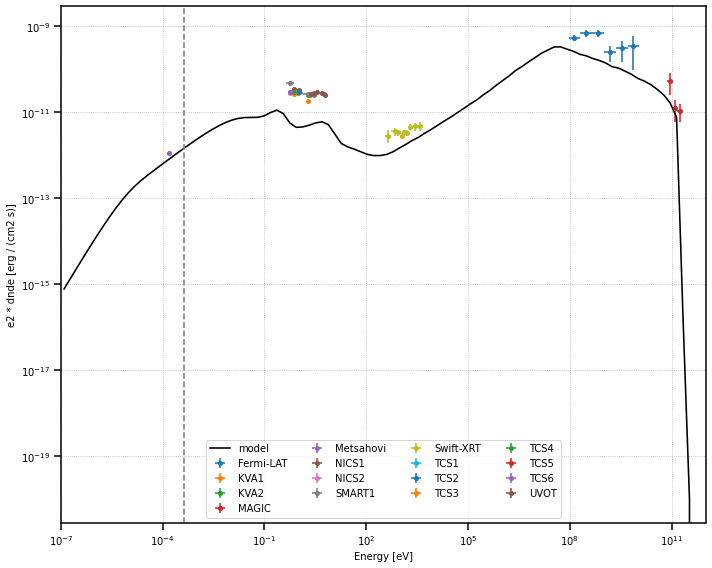

In [11]:
# plot the starting model and the flux points
load_mpl_rc()
fig, ax = plt.subplots(figsize=(10, 8))

for key in flux_points.keys():
    flux_points[key].plot(ax=ax, label=key)

model.spectral_model.plot(
    energy_bounds=[1e-7, 1e12] * u.eV, 
    energy_power=2, 
    label="model", 
    color="k", 
    lw=1.6
)

# plot a line marking the minimum energy considered in the fit
ax.axvline(E_min_fit, ls="--", color="gray")

plt.legend(ncol=4)
plt.xlim([1e-7, 1e12])
plt.show()

In [12]:
%%time
# define the fitter
fitter = Fit()
results = fitter.run(datasets)

/home/cosimo/software/miniconda3/envs/gammapy-0.20.1/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/cosimo/software/miniconda3/envs/gammapy-0.20.1/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/cosimo/software/miniconda3/envs/gammapy-0.20.1/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/cosimo/software/miniconda3/envs/gammapy-0.20.1/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/cosimo/software/miniconda3/envs/gammapy-0.20.1

CPU times: user 3min 2s, sys: 1.96 s, total: 3min 4s
Wall time: 3min 4s


In [13]:
print(results)
print(model.spectral_model.parameters.to_table())

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization failed.
	nfev       : 148
	total stat : nan

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

  type         name         value      unit     error      min        max    frozen is_norm link
-------- --------------- ----------- -------- --------- ---------- --------- ------ ------- ----
spectral       log10_k_e -1.3010e+00                nan -1.000e+01 2.000e+00  False   False     
spectral              p1  1.8000e+00                nan  1.000e+00 5.000e+00  False   False     
spectral              p2  3.5000e+00                nan  1.000e+00 5.000e+00  False   False     
spectral   log10_gamma_b  2.6990e+00                nan  2.000e+00 6.000e+00  False   False     
spectral log10_gamma_min  0.0000e+00          0.000e+00  1.000e+00 3.000e+00   True   False     
spectral log10_gamma_max  4.6021e+00          0.

/home/cosimo/software/miniconda3/envs/gammapy-0.20.1/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/cosimo/software/miniconda3/envs/gammapy-0.20.1/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/cosimo/software/miniconda3/envs/gammapy-0.20.1/lib/python3.8/site-packages/astropy/units/quantity.py:613: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


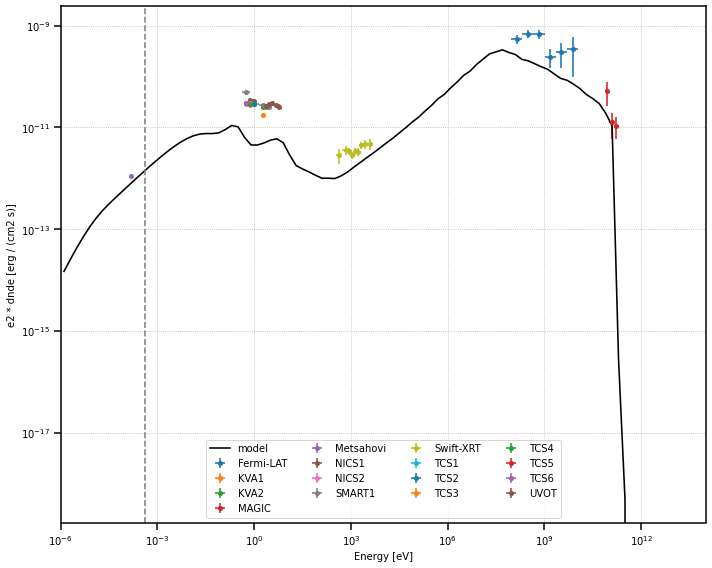

In [14]:
# plot the final model and the flux points
fig, ax = plt.subplots(figsize=(10, 8))

for key in flux_points.keys():
    flux_points[key].plot(ax=ax, label=key)

model.spectral_model.plot(
    energy_bounds=[1e-6, 1e14] * u.eV,
    energy_power=2,
    label="model",
    color="k",
    lw=1.6
)

# plot a line marking the minimum energy considered in the fit
ax.axvline(E_min_fit, ls="--", color="gray")
    
plt.legend(ncol=4)
plt.xlim([1e-6, 1e14])
plt.show()